# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math

In [2]:
%load_ext autoreload
%autoreload 2
from elec_forecast.bootstrap_filter_model import BootstrapFilterModel
from elec_forecast.rm_estimation import RmEstimation
from elec_forecast.particle_filter import ParticleFilter

### Parameters

In [3]:
M=10**3 #number of particles
n_pred=365  #number of predictions
N_daytype=8  #number of day types

### Load temperatures data 2015-2016

In [4]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [5]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [6]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [7]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])

### Daytype

In [8]:
daytype=np.array(df.daytype)

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [9]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
pred_forward=[0,1,2]

In [10]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180113-135329.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init

{'g_heat_init': array([-814623.94530988,   -1103.5042025 ,  -13509.35223552,
         -12839.18874712,  -13810.69394068,  -13621.95767042,
         -16305.45122647,  -16251.90232773,  -16229.3696953 ,
         -17229.49394215,  -13669.17597616,  -15726.25635544,
         -14808.97478176,  -14519.69267177,  -13655.86349596,
         -13546.63330023,  -13762.6351832 ,  -16223.92473751,
         -16231.78960435,  -17198.22294889,  -16084.04185055,
         -14859.33888566,  -15086.97652322,  -15659.32736924,
         -15025.21396291,  -16876.95500528,  -18016.91503558,
         -14386.93382501,  -14456.1228341 ,  -17258.13559834,
         -16399.27181928,  -14184.38234493,  -17037.65684651,
         -17577.66776037,  -15905.47860891,  -14955.89959227,
         -16811.49451007,  -15179.88058645,  -16273.87576028,
         -16666.00910714,  -16425.26301396,  -17107.27359641,
         -17374.00623292,  -13665.90412278,  -16588.1106145 ,
         -16457.00065552,  -16112.43401709,  -15547.969

In [11]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [12]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*10**4
sigma_s_init=np.ones(M)*10**4
kappa=np.ones(M)*1/9

In [13]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [40]:
pf = ParticleFilter(consumption_day_ahead, 
                    T_h, 
                    daytype, 
                    n_pred, 
                    M, 
                    x_init, 
                    w_init,
                    kappa,
                    u_h, 
                    sigma_s_init, 
                    sigma_g_init, 
                    s_init, 
                    g_heat_init, 
                    sigma2)

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [41]:
x_predict, ESS_calc = pf.predict(pred_forward, n_pred, len_init)

n= 1
x_pred_mean = 5.52e+04 real consumption= 6.86e+04
x_pred min= 5.52e+04 x_pred max 5.52e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 2
x_pred_mean = 5.55e+04 real consumption= 6.41e+04
x_pred min= 5.55e+04 x_pred max 5.55e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 3
x_pred_mean = 5.78e+04 real consumption= 5.74e+04
x_pred min= 5.78e+04 x_pred max 5.78e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 4
x_pred_mean = 7.03e+04 real consumption= 7.31e+04
x_pred min= 7.03e+04 x_pred max 7.03e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 5
x_pred_mean = 8.22e+04 real consumption= 7.68e+04
x_pred min= 8.22e+04 x_pred max 8.22e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 6
x_pred_mean = 9.06e+04 real consumption= 7.49

C:\Users\Zakarya\workspace\smc_electricity_forecast\elec_forecast\particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 41
No heating effect
x_pred_mean = 2.20e+04 real consumption= 7.16e+04
x_pred min= 2.20e+04 x_pred max 2.20e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 42
x_pred_mean = 1.65e+05 real consumption= 7.21e+04
x_pred min= 1.65e+05 x_pred max 1.65e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 43
No heating effect
x_pred_mean = 2.42e+04 real consumption= 7.10e+04
x_pred min= 2.42e+04 x_pred max 2.42e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 44
No heating effect
x_pred_mean = 2.43e+04 real consumption= 6.39e+04
x_pred min= 2.43e+04 x_pred max 2.43e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 45
No heating effect
x_pred_mean = 2.36e+04 real consumption= 5.91e+04
x_pred min= 2.

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 108
No heating effect
x_pred_mean = 1.04e+04 real consumption= 4.20e+04
x_pred min= 1.04e+04 x_pred max 1.04e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 109
No heating effect
x_pred_mean = 9.02e+03 real consumption= 5.22e+04
x_pred min= 9.02e+03 x_pred max 9.02e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 110
No heating effect
x_pred_mean = 9.54e+03 real consumption= 5.22e+04
x_pred min= 9.54e+03 x_pred max 9.54e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 111
No heating effect
x_pred_mean = 9.64e+03 real consumption= 5.20e+04
x_pred min= 9.64e+03 x_pred max 9.64e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 112
No heating effect
x_pred_mean = 6.61e+03 real consumption= 

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 177
No heating effect
x_pred_mean = 9.77e+04 real consumption= 4.52e+04
x_pred min= 9.77e+04 x_pred max 9.77e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 178
No heating effect
x_pred_mean = 1.17e+05 real consumption= 4.11e+04
x_pred min= 1.17e+05 x_pred max 1.17e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 179
No heating effect
x_pred_mean = 1.02e+05 real consumption= 5.50e+04
x_pred min= 1.02e+05 x_pred max 1.02e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 180
No heating effect
x_pred_mean = 8.20e+04 real consumption= 5.66e+04
x_pred min= 8.20e+04 x_pred max 8.20e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 181
No heating effect
x_pred_mean = 8.91e+04 real consumption= 

No heating effect
x_pred_mean = 4.05e+05 real consumption= 5.22e+04
x_pred min= 4.05e+05 x_pred max 4.05e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 258
No heating effect
x_pred_mean = 3.86e+05 real consumption= 5.38e+04
x_pred min= 3.86e+05 x_pred max 3.86e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 259
No heating effect
x_pred_mean = 4.14e+05 real consumption= 5.30e+04
x_pred min= 4.14e+05 x_pred max 4.14e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 260
No heating effect
x_pred_mean = 3.53e+05 real consumption= 5.13e+04
x_pred min= 3.53e+05 x_pred max 3.53e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 261
No heating effect
x_pred_mean = 3.98e+05 real consumption= 4.41e+04
x_pred min= 3.98e+05 x_pred max 3.98e+05
ESS of normalized weights= nan
ESS critically l

ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 299
No heating effect
x_pred_mean = 3.17e+05 real consumption= 5.66e+04
x_pred min= 3.17e+05 x_pred max 3.17e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 300
No heating effect
x_pred_mean = 3.36e+05 real consumption= 5.72e+04
x_pred min= 3.36e+05 x_pred max 3.36e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 301
No heating effect
x_pred_mean = 3.33e+05 real consumption= 5.67e+04
x_pred min= 3.33e+05 x_pred max 3.33e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 302
No heating effect
x_pred_mean = 3.49e+05 real consumption= 5.47e+04
x_pred min= 3.49e+05 x_pred max 3.49e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.271115
------------------------
n= 303
No heating effect
x_pred_mean = 3.24e+05 real consumpt

x_pred_mean = 5.52e+05 real consumption= 7.03e+04
x_pred min= 5.52e+05 x_pred max 5.52e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 15
x_pred_mean = 7.54e+05 real consumption= 7.00e+04
x_pred min= 7.54e+05 x_pred max 7.54e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 16
x_pred_mean = 8.52e+05 real consumption= 6.31e+04
x_pred min= 8.52e+05 x_pred max 8.52e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 17
x_pred_mean = 1.35e+06 real consumption= 6.25e+04
x_pred min= 1.35e+06 x_pred max 1.35e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 18
x_pred_mean = 1.08e+06 real consumption= 7.72e+04
x_pred min= 1.08e+06 x_pred max 1.08e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 19
x_pred_mean = 1.48e+06 real consumption=

No heating effect
x_pred_mean = 1.09e+05 real consumption= 6.07e+04
x_pred min= 1.09e+05 x_pred max 1.09e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 89
No heating effect
x_pred_mean = 1.08e+05 real consumption= 6.07e+04
x_pred min= 1.08e+05 x_pred max 1.08e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 90
No heating effect
x_pred_mean = 1.09e+05 real consumption= 6.23e+04
x_pred min= 1.09e+05 x_pred max 1.09e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 91
No heating effect
x_pred_mean = 1.09e+05 real consumption= 6.36e+04
x_pred min= 1.09e+05 x_pred max 1.09e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 92
No heating effect
x_pred_mean = 1.07e+05 real consumption= 6.11e+04
x_pred min= 1.07e+05 x_pred max 1.07e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ES

No heating effect
x_pred_mean = 9.73e+04 real consumption= 5.31e+04
x_pred min= 9.73e+04 x_pred max 9.73e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 153
No heating effect
x_pred_mean = 8.92e+04 real consumption= 5.38e+04
x_pred min= 8.92e+04 x_pred max 8.92e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 154
No heating effect
x_pred_mean = 8.89e+04 real consumption= 5.43e+04
x_pred min= 8.89e+04 x_pred max 8.89e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 155
No heating effect
x_pred_mean = 8.89e+04 real consumption= 5.44e+04
x_pred min= 8.89e+04 x_pred max 8.89e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 156
No heating effect
x_pred_mean = 9.73e+04 real consumption= 4.49e+04
x_pred min= 9.73e+04 x_pred max 9.73e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
ne

No heating effect
x_pred_mean = 2.67e+05 real consumption= 4.74e+04
x_pred min= 2.67e+05 x_pred max 2.67e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234182
------------------------
n= 223
No heating effect
x_pred_mean = 2.82e+05 real consumption= 4.85e+04
x_pred min= 2.82e+05 x_pred max 2.82e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234182
------------------------
n= 224
No heating effect
x_pred_mean = 2.74e+05 real consumption= 4.77e+04
x_pred min= 2.74e+05 x_pred max 2.74e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234182
------------------------
n= 225
No heating effect
x_pred_mean = 3.07e+05 real consumption= 4.59e+04
x_pred min= 3.07e+05 x_pred max 3.07e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234182
------------------------
n= 226
No heating effect
x_pred_mean = 3.02e+05 real consumption= 3.89e+04
x_pred min= 3.02e+05 x_pred max 3.02e+05
ESS of normalized weights= nan
ESS critically l

No heating effect
x_pred_mean = 2.98e+05 real consumption= 4.41e+04
x_pred min= 2.98e+05 x_pred max 2.98e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 262
No heating effect
x_pred_mean = 3.08e+05 real consumption= 3.99e+04
x_pred min= 3.08e+05 x_pred max 3.08e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 263
No heating effect
x_pred_mean = 3.14e+05 real consumption= 5.12e+04
x_pred min= 3.14e+05 x_pred max 3.14e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 264
No heating effect
x_pred_mean = 3.32e+05 real consumption= 5.29e+04
x_pred min= 3.32e+05 x_pred max 3.32e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 265
No heating effect
x_pred_mean = 3.45e+05 real consumption= 5.27e+04
x_pred min= 3.45e+05 x_pred max 3.45e+05
ESS of normalized weights= nan
ESS critically low
n

No heating effect
x_pred_mean = 7.02e+05 real consumption= 5.90e+04
x_pred min= 7.02e+05 x_pred max 7.02e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 339
No heating effect
x_pred_mean = 7.04e+05 real consumption= 5.30e+04
x_pred min= 7.04e+05 x_pred max 7.04e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 340
No heating effect
x_pred_mean = 7.09e+05 real consumption= 6.14e+04
x_pred min= 7.09e+05 x_pred max 7.09e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 341
No heating effect
x_pred_mean = 7.11e+05 real consumption= 6.45e+04
x_pred min= 7.11e+05 x_pred max 7.11e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23418
------------------------
n= 342
No heating effect
x_pred_mean = 7.19e+05 real consumption= 6.41e+04
x_pred min= 7.19e+05 x_pred max 7.19e+05
ESS of normalized weights= nan
ESS critically low
n

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 17
x_pred_mean = 2.43e+05 real consumption= 6.25e+04
x_pred min= 2.43e+05 x_pred max 2.43e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 18
x_pred_mean = 3.26e+05 real consumption= 7.72e+04
x_pred min= 3.26e+05 x_pred max 3.26e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 19
x_pred_mean = 5.70e+04 real consumption= 7.79e+04
x_pred min= 5.70e+04 x_pred max 5.70e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 20
x_pred_mean = 5.67e+04 real consumption= 7.92e+04
x_pred min= 5.67e+04 x_pred max 5.67e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 21
x_pred_mean = 2.43e+04 real consumption= 7.84e+04
x_pred min= 2.43e+04 x_pred max 2.43e+04
ESS of normalized weights= 862.234232
ESS>=0

No heating effect
x_pred_mean = 8.78e+04 real consumption= 6.07e+04
x_pred min= 8.78e+04 x_pred max 8.78e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 89
No heating effect
x_pred_mean = 8.72e+04 real consumption= 6.07e+04
x_pred min= 8.72e+04 x_pred max 8.72e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 90
No heating effect
x_pred_mean = 8.07e+04 real consumption= 6.23e+04
x_pred min= 8.07e+04 x_pred max 8.07e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 91
No heating effect
x_pred_mean = 9.38e+04 real consumption= 6.36e+04
x_pred min= 9.38e+04 x_pred max 9.38e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 92
No heating effect
x_pred_mean = 8.14e+04 real consumption= 6.11e+04
x_pred min= 8.14e+04 x_pred max 8.14e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ES

No heating effect
x_pred_mean = 3.92e+05 real consumption= 5.18e+04
x_pred min= 3.92e+05 x_pred max 3.92e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 149
No heating effect
x_pred_mean = 3.79e+05 real consumption= 4.41e+04
x_pred min= 3.79e+05 x_pred max 3.79e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 150
No heating effect
x_pred_mean = 3.79e+05 real consumption= 4.00e+04
x_pred min= 3.79e+05 x_pred max 3.79e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 151
No heating effect
x_pred_mean = 4.16e+05 real consumption= 5.20e+04
x_pred min= 4.16e+05 x_pred max 4.16e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 152
No heating effect
x_pred_mean = 4.28e+05 real consumption= 5.31e+04
x_pred min= 4.28e+05 x_pred max 4.28e+05
ESS of normalized weights= nan
ESS critically l

No heating effect
x_pred_mean = 4.81e+05 real consumption= 5.43e+04
x_pred min= 4.81e+05 x_pred max 4.81e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 190
No heating effect
x_pred_mean = 4.70e+05 real consumption= 5.41e+04
x_pred min= 4.70e+05 x_pred max 4.70e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 191
No heating effect
x_pred_mean = 4.67e+05 real consumption= 4.65e+04
x_pred min= 4.67e+05 x_pred max 4.67e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 192
No heating effect
x_pred_mean = 4.63e+05 real consumption= 4.12e+04
x_pred min= 4.63e+05 x_pred max 4.63e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 193
No heating effect
x_pred_mean = 4.89e+05 real consumption= 4.97e+04
x_pred min= 4.89e+05 x_pred max 4.89e+05
ESS of normalized weights= nan
ESS critically l

x_pred min= 6.05e+05 x_pred max 6.05e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 232
No heating effect
x_pred_mean = 6.09e+05 real consumption= 4.82e+04
x_pred min= 6.09e+05 x_pred max 6.09e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 233
No heating effect
x_pred_mean = 6.08e+05 real consumption= 4.29e+04
x_pred min= 6.08e+05 x_pred max 6.08e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 234
No heating effect
x_pred_mean = 6.10e+05 real consumption= 3.84e+04
x_pred min= 6.10e+05 x_pred max 6.10e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 235
No heating effect
x_pred_mean = 6.06e+05 real consumption= 4.96e+04
x_pred min= 6.06e+05 x_pred max 6.06e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 236
No heating ef

new ESS= 862.234232
------------------------
n= 271
x_pred_mean = 9.96e+05 real consumption= 5.25e+04
x_pred min= 9.96e+05 x_pred max 9.96e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 272
No heating effect
x_pred_mean = 6.28e+05 real consumption= 5.28e+04
x_pred min= 6.28e+05 x_pred max 6.28e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 273
No heating effect
x_pred_mean = 6.30e+05 real consumption= 5.31e+04
x_pred min= 6.30e+05 x_pred max 6.30e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 274
No heating effect
x_pred_mean = 6.34e+05 real consumption= 5.21e+04
x_pred min= 6.34e+05 x_pred max 6.34e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 275
No heating effect
x_pred_mean = 6.43e+05 real consumption= 4.55e+04
x_pred min= 6.43e+05 x_pred max 6.43e+05
ESS of normal

ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 313
x_pred_mean = 2.56e+06 real consumption= 5.49e+04
x_pred min= 2.56e+06 x_pred max 2.56e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 314
x_pred_mean = 1.76e+06 real consumption= 4.69e+04
x_pred min= 1.76e+06 x_pred max 1.76e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 315
No heating effect
x_pred_mean = 7.30e+05 real consumption= 5.65e+04
x_pred min= 7.30e+05 x_pred max 7.30e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 316
No heating effect
x_pred_mean = 7.28e+05 real consumption= 5.67e+04
x_pred min= 7.28e+05 x_pred max 7.28e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 317
No heating effect
x_pred_mean = 7.20e+05 real consumption= 5.10e+04
x_pred min= 7.20e+05 x

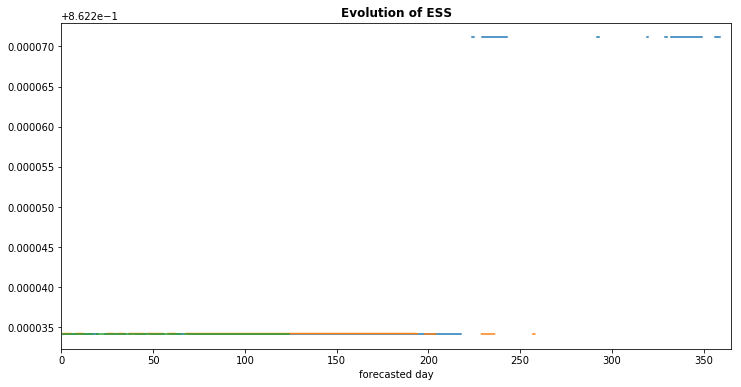

In [42]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,n_pred),ESS_calc[0,1:n_pred]/M)
plt.plot(range(1,n_pred),ESS_calc[1,1:n_pred]/M)
plt.plot(range(1,n_pred),ESS_calc[2,1:n_pred]/M)

plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

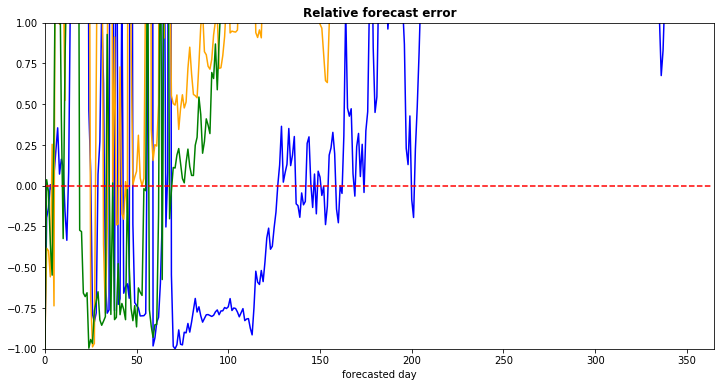

In [43]:
fig=plt.figure(figsize=(12,6))


plt.plot(range(n_pred),(x_predict[0,:]-consumption_day_ahead[:n_pred])/consumption_day_ahead[:n_pred],color='blue')
plt.plot(range(n_pred),(x_predict[1,:]-consumption_day_ahead[1:n_pred+1])/consumption_day_ahead[1:n_pred+1],color='orange')
plt.plot(range(n_pred),(x_predict[2,:]-consumption_day_ahead[2:n_pred+2])/consumption_day_ahead[2:n_pred+2],color='green')

plt.plot(range(n_pred-1),np.zeros(n_pred-1),color='red',linestyle='--')
plt.ylim(-1,1)
plt.xlim(0,n_pred)
plt.xlabel('forecasted day')
plt.title("Relative forecast error",fontweight='bold')
plt.show()

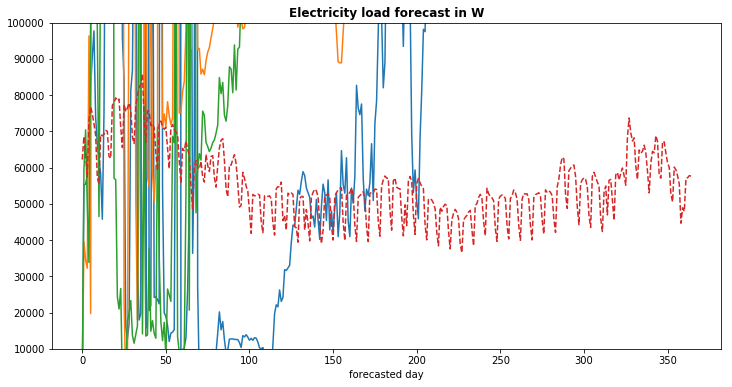

In [44]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred),x_predict[0,:])
plt.plot(range(n_pred),x_predict[1,:])
plt.plot(range(n_pred),x_predict[2,:])
plt.plot(range(n_pred),consumption_day_ahead[:n_pred],linestyle='--')
plt.xlabel('forecasted day')
plt.ylim(10**4,10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [45]:
len_filter_pmmh=365
len_iter_mha=2

#### PMMH Algorithm

In [46]:
pf.pmmh(len_filter_pmmh, len_iter_mha, pred_forward, len_init)

log_prior_init= [-55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.09865012
 -55.09865012 -55.09865012 -55.09865012 -55.09865012 -55.098

C:\Users\Zakarya\workspace\smc_electricity_forecast\elec_forecast\particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 24
x_pred_mean = 2.95e+05 real consumption= 6.55e+04
x_pred min= 2.95e+05 x_pred max 2.95e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.234232
------------------------
n= 25
x_pred_mean = 1.83e+05 real consumption= 7.75e+04
x_pred min= 1.83e+05 x_pred max 1.83e+05
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 26
No heating effect
x_pred_mean = 8.58e+03 real consumption= 7.54e+04
x_pred min= 8.58e+03 x_pred max 8.58e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 27
No heating effect
x_pred_mean = 6.08e+03 real consumption= 7.65e+04
x_pred min= 6.08e+03 x_pred max 6.08e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 28
No heating effect
x_pred_mean = 5.25e+02 real consumption= 7.78e+04
x_pred min= 5.25e+02 x_pred ma

No heating effect
x_pred_mean = 3.48e+04 real consumption= 5.41e+04
x_pred min= 3.48e+04 x_pred max 3.48e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 87
No heating effect
x_pred_mean = 5.05e+04 real consumption= 5.19e+04
x_pred min= 5.05e+04 x_pred max 5.05e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 88
No heating effect
x_pred_mean = 7.24e+03 real consumption= 6.07e+04
x_pred min= 7.24e+03 x_pred max 7.24e+03
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 89
No heating effect
x_pred_mean = 6.85e+04 real consumption= 6.07e+04
x_pred min= 6.85e+04 x_pred max 6.85e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232
------------------------
n= 90
No heating effect
x_pred_mean = 5.99e+04 real consumption= 6.23e+04
x_pred min= 5.99e+04 x_pred max 5.99e+04
ESS of normalized weights= 862.234232
ESS>=0.5*M
new ES

No heating effect
x_pred_mean = 2.53e+05 real consumption= 5.26e+04
x_pred min= 2.53e+05 x_pred max 2.53e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 127
No heating effect
x_pred_mean = 2.43e+05 real consumption= 4.37e+04
x_pred min= 2.43e+05 x_pred max 2.43e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 128
No heating effect
x_pred_mean = 2.52e+05 real consumption= 4.34e+04
x_pred min= 2.52e+05 x_pred max 2.52e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23424
------------------------
n= 129
No heating effect
x_pred_mean = 2.56e+05 real consumption= 3.94e+04
x_pred min= 2.56e+05 x_pred max 2.56e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23424
------------------------
n= 130
No heating effect
x_pred_mean = 2.67e+05 real consumption= 5.15e+04
x_pred min= 2.67e+05 x_pred max 2.67e+05
ESS of normalized weights= nan
ESS critically low
new E

No heating effect
x_pred_mean = 1.61e+05 real consumption= 5.27e+04
x_pred min= 1.61e+05 x_pred max 1.61e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 168
No heating effect
x_pred_mean = 1.75e+05 real consumption= 5.34e+04
x_pred min= 1.75e+05 x_pred max 1.75e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 169
No heating effect
x_pred_mean = 1.96e+05 real consumption= 5.13e+04
x_pred min= 1.96e+05 x_pred max 1.96e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 170
No heating effect
x_pred_mean = 1.94e+05 real consumption= 4.36e+04
x_pred min= 1.94e+05 x_pred max 1.94e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 171
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.96e+04
x_pred min= 1.99e+05 x_pred max 1.99e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 86

x_pred_mean = 1.44e+05 real consumption= 5.26e+04
x_pred min= 1.44e+05 x_pred max 1.44e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 239
No heating effect
x_pred_mean = 1.45e+05 real consumption= 5.15e+04
x_pred min= 1.45e+05 x_pred max 1.45e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 240
No heating effect
x_pred_mean = 1.57e+05 real consumption= 4.51e+04
x_pred min= 1.57e+05 x_pred max 1.57e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 241
No heating effect
x_pred_mean = 1.53e+05 real consumption= 4.13e+04
x_pred min= 1.53e+05 x_pred max 1.53e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 242
No heating effect
x_pred_mean = 1.72e+05 real consumption= 5.43e+04
x_pred min= 1.72e+05 x_pred max 1.72e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
----------

No heating effect
x_pred_mean = 1.14e+05 real consumption= 6.07e+04
x_pred min= 1.14e+05 x_pred max 1.14e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 295
No heating effect
x_pred_mean = 9.85e+04 real consumption= 5.75e+04
x_pred min= 9.85e+04 x_pred max 9.85e+04
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 296
No heating effect
x_pred_mean = 1.22e+05 real consumption= 4.92e+04
x_pred min= 1.22e+05 x_pred max 1.22e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 297
No heating effect
x_pred_mean = 1.05e+05 real consumption= 4.42e+04
x_pred min= 1.05e+05 x_pred max 1.05e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 298
No heating effect
x_pred_mean = 1.27e+05 real consumption= 5.57e+04
x_pred min= 1.27e+05 x_pred max 1.27e+05
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 86

x_pred_mean = 2.70e+04 real consumption= 5.54e+04
x_pred min= 2.70e+04 x_pred max 2.70e+04
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 358
x_pred_mean = 6.63e+04 real consumption= 4.47e+04
x_pred min= 6.63e+04 x_pred max 6.63e+04
ESS of normalized weights= 862.23424
ESS>=0.5*M
new ESS= 862.23424
------------------------
n= 359
x_pred_mean = 4.77e+05 real consumption= 4.89e+04
x_pred min= 4.77e+05 x_pred max 4.77e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23424
------------------------
n= 360
x_pred_mean = 1.35e+06 real consumption= 4.79e+04
x_pred min= 1.35e+06 x_pred max 1.35e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23424
------------------------
n= 361
x_pred_mean = 2.15e+06 real consumption= 5.70e+04
x_pred min= 2.15e+06 x_pred max 2.15e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 862.23424
------------------------
n= 362
x_pred_mean = 4.02e+06 real consumption= 5.7

ValueError: size does not match the broadcast shape of the parameters.